In [493]:
import sys
sys.path.append('C:/project_WWTP/python')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from scipy.stats import zscore
import scipy.stats as stats
from tqdm import tqdm

# PyTorch 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle

import notebook.feature.WF_feature_selection as wf_fs
import notebook.feature.feature_engineering as feat_eng

In [494]:
BASE_DIR = Path.cwd().resolve().parent.parent

In [495]:
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "model"
RESULTS_DIR = BASE_DIR / "results" / "DL"
NOTEBOOK_DIR = BASE_DIR / "notebook" / "DL"

MODEL_SAVE_DIR = MODEL_DIR
SCALER_SAVE_DIR = MODEL_DIR

RESULTS_SAVE_DIR = RESULTS_DIR
PLOTS_SAVE_DIR = RESULTS_DIR / "plots"
METRICS_SAVE_DIR = RESULTS_DIR / "metrics"

In [541]:
MODE_CONFIGS = {
    "flow": {
        # ====== 최적화된 하이퍼파라미터 ======
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.3,  # 0.3→0.25: 과적합 방지하되 학습 용량 확보
        "learning_rate": 1e-3,  # 3e-4→2e-4: 더 안정적인 수렴
        "batch_size": 64,
        "window_size": 48,  # 24시간 (30분 단위: 48 steps)
        "output_size": 1,
        "horizon": 2,  # 1시간 후 예측 (30분 단위: 2 steps)
    },
    "toc": {  # TOC_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 4,
        "dropout": 0.35,
        "learning_rate": 5e-4,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "ss": {  # SS_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "tn": {  # TN_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "tp": {  # TP_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "flux": {  # FLUX_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.2,
        "learning_rate": 5e-4,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "ph": {  # PH_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
}

In [497]:
MODE = "flow"  # flow, toc, ss, tn, tp, flux, ph

HORIZON = MODE_CONFIGS.get("horizon", 1)  # 기본값 1 (30분)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if MODE not in MODE_CONFIGS:
    raise ValueError(f"Unknown MODE: {MODE}. Available modes: {list(MODE_CONFIGS.keys())}")

CONFIG = MODE_CONFIGS[MODE]
WINDOW_SIZE = CONFIG["window_size"]                # 슬라이딩 윈도우
LSTM_CONFIG = {
    "hidden_size": CONFIG["hidden_size"],          # LSTM 은닉층 유닛 수
    "num_layers": CONFIG["num_layers"],            # 쌓인 LSTM 레이어 수
    "dropout": CONFIG["dropout"],             # 정규화를 위한 드롭아웃 비율
    "output_size": CONFIG["output_size"],           # 출력 차원 
    "bidirectional": False,     # 양방향 LSTM 사용 여부
}

TRAINING_CONFIG = {
    "batch_size": CONFIG["batch_size"],           # 학습 배치 크기
    "learning_rate": CONFIG["learning_rate"],     # 옵티마이저 학습률
    "num_epochs": 100,          # 최대 학습 에포크 수
    "patience": 20,             # 조기 종료 patience
    "optimizer": "adam",        # 옵티마이저 타입: 'adam', 'rmsprop', 'sgd'
    "loss_function": "mse",     # 손실 함수: 'mse' 또는 'mae'
}

SPLIT_RATIOS = {
    "train": 0.7,               # 학습 세트 비율
    "val": 0.15,                # 검증 세트 비율
    "test": 0.15,               # 테스트 세트 비율
}

FLOW_TARGET = "Q_in"
TOC_TARGET = "TOC_VU"
SS_TARGET = "SS_VU"
TN_TARGET = "TN_VU"
TP_TARGET = "TP_VU"
FLUX_TARGET = "FLUX_VU"
PH_TARGET = "PH_VU"

VISUALIZATION_CONFIG = {
    "dpi": 300,                 # 플롯 해상도
    "figsize": (10, 6),         # 그림 크기 (너비, 높이)
    "font_family": "Malgun Gothic",  # 한글 폰트 지원
    "grid": True,               # 플롯에 그리드 표시
}

RANDOM_SEED = 42

TIME_COL = "SYS_TIME"

In [498]:
def load_data(DATA_DIR):
    dfs = {}

    dfs['flow'] = pd.read_csv(DATA_DIR / "actual/FLOW_Actual.csv")
    dfs['flow']['Q_in'] = dfs['flow']["flow_TankA"] + dfs['flow']['flow_TankB']
    dfs['flow']['level_sum'] = dfs['flow']['level_TankA'] + dfs['flow']['level_TankB']
    dfs['flow'] = dfs['flow'].drop(columns=["data_save_dt"])
    dfs['tms'] = pd.read_csv(DATA_DIR / "actual/TMS_Actual.csv")
    for station_id in ["368", "541", "569"]:
        aws_path = DATA_DIR / f"actual/AWS_{station_id}.csv"
        df = pd.read_csv(aws_path)
        if "datetime" in df.columns:
            time_col = df["datetime"]
            df = df.drop(columns=["datetime","YYMMDDHHMI","STN"], errors="ignore")
            df = df.add_suffix(f"_{station_id}")
            df["SYS_TIME"] = time_col
        else:
            df = df.drop(columns=["YYMMDDHHMI", "STN"], errors="ignore")
            df = df.add_suffix(f"_{station_id}")
        dfs[f"aws{station_id}"] = df

    return dfs

In [499]:
def set_datetime_index(df, time_col):
    out = df.copy()
    
    # 시간 컬럼이 존재하는지 확인
    if time_col not in out.columns:
        raise ValueError(f"시간 컬럼 '{time_col}'이 데이터프레임에 없습니다. 사용 가능한 컬럼: {out.columns.tolist()}")
    
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out = out.dropna(subset=[time_col])
    out = out.set_index(time_col).sort_index()
    return out

In [500]:
def align_data(dfs):
    aligned_dfs = {}
    for name, df in dfs.items():
        time_col = TIME_COL
        df_aligned = set_datetime_index(df, time_col)

        df_aligned = df_aligned.resample("1min").ffill()

        aligned_dfs[name] = df_aligned
            
    return aligned_dfs


In [501]:
def merge_data(dfs):

    valid = {}
    merged_dfs = {}

    for name, df in dfs.items():
        df2 = df.sort_index()
        if df2.index.has_duplicates:
            df2 = df2[~df2.index.duplicated(keep="last")]
        valid[name] = df2

    for name, df in valid.items():
        if name == "flow":
            merged_dfs[name] = pd.concat([
                df,
                valid["aws368"],
                valid["aws541"],
                valid["aws569"],
            ], axis = 1, join = "inner")

        if name == "tms":
            merged_dfs[name] = pd.concat([
                df,
                valid["aws368"],
                valid["aws541"],
                valid["aws569"]
            ], axis = 1, join = "inner")

    return merged_dfs

In [502]:
@dataclass
class ImputationConfig:
    short_term_hours: int = 3
    medium_term_hours: int = 12
    long_term_hours: int = 48
    ewma_span: int = 6

@dataclass
class OutlierConfig:
    method: str = "iqr"
    iqr_threshold: float = 1.5
    zscore_threshold: float = 3.0
    require_both: bool = False

In [503]:
def impute_missing(df, freq = "1h", config = ImputationConfig()):
    df_out = df.copy()

    freq_td = pd.Timedelta(freq)
    freq_hours = freq_td.total_seconds() / 3600

    mask_dict = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        series = df[col].copy()
        original_missing = series.isna()

        mask_dict[f"{col}_is_missing"] = original_missing.astype(int)

        limit_short = max(1, int(config.short_term_hours / freq_hours))
        series_ffill = series.ffill(limit = limit_short)
        ffill_mask = original_missing & ~series_ffill.isna()
        mask_dict[f"{col}_imputed_ffill"] = ffill_mask.astype(int)

        still_missing = series_ffill.isna()
        if still_missing.sum() > 0:
            ewma_span = max(1, int(config.ewma_span / freq_hours))
            series_ewma = series_ffill.ewm(span=ewma_span, adjust=False).mean()
            
            limit_medium = max(1, int(config.medium_term_hours / freq_hours))
            missing_groups = (still_missing != still_missing.shift()).cumsum()
            missing_lengths = still_missing.groupby(missing_groups).transform("sum")
            
            medium_mask = still_missing & (missing_lengths > limit_short) & (missing_lengths <= limit_medium)
            series_ffill[medium_mask] = series_ewma[medium_mask]
            mask_dict[f"{col}_imputed_ewma"] = medium_mask.astype(int)
        else:
            mask_dict[f"{col}_imputed_ewma"] = pd.Series(0, index=df.index, dtype=int)

        still_missing_long = series_ffill.isna()
        if still_missing_long.sum() > 0:
            # 장기 결측용 더 긴 span (기본 span의 4배)
            long_ewma_span = max(1, int(config.ewma_span * 4 / freq_hours))
            series_long_ewma = series_ffill.ewm(span=long_ewma_span, adjust=False).mean()
            
            long_mask = still_missing_long
            series_ffill[long_mask] = series_long_ewma[long_mask]
            mask_dict[f"{col}_imputed_long_ewma"] = long_mask.astype(int)
        else:
            mask_dict[f"{col}_imputed_long_ewma"] = pd.Series(0, index=df.index, dtype=int)

        df_out[col] = series_ffill

    df_mask = pd.DataFrame(mask_dict, index=df.index)
    
    return df_out, df_mask

In [504]:
def imputate_data(dfs):
    config_impute = ImputationConfig()
    imputed_dfs = {}
    mask_imputed_dfs = {}

    for name, df in dfs.items():
        print(f"\n{'='*60}")
        print(f"{name} 결측치 처리")
        print(f"{'='*60}")
        print(f"결측치 처리 전:")
        print(f"  총 결측치: {df.isna().sum().sum()}")
        print(f"  결측치 있는 컬럼: {(df.isna().sum() > 0).sum()}개")

        df_imputed, mask_imputed = impute_missing(df, freq="1min", config = config_impute)

        imputed_dfs[name] = df_imputed
        mask_imputed_dfs[name] = mask_imputed

        print(f"\n결측치 처리 후:")
        print(f"  총 결측치: {df_imputed.isna().sum().sum()}")
        print(f"  데이터 shape: {df_imputed.shape}")
        print(f"  마스크 shape: {mask_imputed.shape}")

    return imputed_dfs, mask_imputed_dfs

In [505]:
def outliers_domain(series, col_name):
    outliers = pd.Series([False] * len(series), index = series.index)

    if not pd.api.types.is_numeric_dtype(series):
        return outliers
    
    domain_rules = {
        "TOC_VU": (0, 250),
        "PH_VU": (0, 14),
        "SS_VU": (0, 100),
        "TN_VU": (0, 100),
        "TP_VU": (0, 20),
        "level_TankA": (0, 10),
        "level_TankB": (0, 10),
        "TA": (-30, 45),
        "HM": (0, 100),
        "TD": (-40, 35),
    }

    if col_name in domain_rules:
        lower, upper = domain_rules[col_name]
        outliers = (series < lower) | (series > upper)
    elif "RN_" in col_name:
        outliers = (series < 0) | (series > 300)
    elif "flow" in col_name.lower() or "flux" in col_name.lower():
        valid_values = series.dropna()
        if len(valid_values) > 0:
            outliers = (series < 0) | (series > valid_values.quantile(0.99) * 3)
    else:
        valid_values = series.dropna()
        if len(valid_values) > 0:
            outliers = (series < 0) | (series > valid_values.quantile(0.999) * 2)
    
    return outliers

In [506]:
def outliers_statistical(series, 
                        method = 'iqr', 
                        iqr_threshold = 1.5, 
                        zscore_threshold = 3.0):
    outliers = pd.Series([False] * len(series), index=series.index)

    if not pd.api.types.is_numeric_dtype(series):
        return outliers
    
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_threshold * IQR
        upper = Q3 + iqr_threshold * IQR
        outliers = (series < lower) | (series > upper)
    
    elif method == 'zscore':
        # NaN 제거 후 Z-score 계산
        valid_mask = ~series.isna()
        if valid_mask.sum() > 0:
            z_scores = np.abs(zscore(series[valid_mask]))
            outliers[valid_mask] = z_scores > zscore_threshold
    
    return outliers

In [507]:
def process_outliers(df, config = OutlierConfig(), ewma_span = 12):
    df_out = df.copy()
    mask_dict = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        series = df[col].copy()

        domain_outliers = outliers_domain(series, col)

        stats_outliers = outliers_statistical(series, method = config.method, iqr_threshold=config.iqr_threshold, zscore_threshold=config.zscore_threshold)

        if config.require_both:
            final_outliers = domain_outliers & stats_outliers
        else:
            final_outliers = domain_outliers | stats_outliers

        mask_dict[f"{col}_outlier_domain"] = domain_outliers.astype(int)
        mask_dict[f"{col}_outlier_stats"] = stats_outliers.astype(int)
        mask_dict[f"{col}_outlier_final"] = final_outliers.astype(int)

        # EWMA로 이상치 대체
        if final_outliers.sum() > 0:
            # 1. 이상치를 NaN으로 변환한 시리즈 생성
            series_clean = series.copy()
            series_clean[final_outliers] = np.nan
            
            # 2. 깨끗한 데이터로 EWMA 계산
            series_ewma = series_clean.ewm(span=ewma_span, adjust=False).mean()
            
            # 3. 이상치 위치를 EWMA로 대체
            mask_dict[f"{col}_outlier_replaced_ewma"] = final_outliers.astype(int)
        else:
            mask_dict[f"{col}_outlier_replaced_ewma"] = pd.Series(0, index=df.index, dtype=int)

        df_out[col] = series

    df_mask = pd.DataFrame(mask_dict, index=df.index)

    return df_out, df_mask

In [508]:
def handle_outliers(dfs):
    config_outlier = OutlierConfig()
    processed_dfs = {}
    mask_processed_dfs = {}

    for name, df in dfs.items():
        print(f"\n{'='*60}")
        print(f"{name} 이상치 처리")
        print(f"{'='*60}")

        df_outlier, mask_outlier = process_outliers(df, config = config_outlier, ewma_span = 12)

        processed_dfs[name] = df_outlier
        mask_processed_dfs[name] = mask_outlier

    return processed_dfs, mask_processed_dfs

In [509]:
def resample_data(df, freq = "30min", rain_cols=None, other_cols=None):
    if not isinstance(df.index, pd.DatetimeIndex) :
        raise ValueError("리샘플링을 위해서는 DatetimeIndex가 필요합니다")
    
    numeric_cols = df.select_dtypes(include = [np.number]).columns
    df_numeric = df[numeric_cols]

    agg_dict = {}
    for col in numeric_cols:
        if col.startswith("RN_") or col.startswith("AR_"):
            agg_dict[col] = "sum"  # ← 강수량은 누적
        else:
            agg_dict[col] = "mean"
    
    return df_numeric.resample(freq).agg(agg_dict)

In [510]:
def preprocess_data(dfs):
    # 시간 축 정렬
    aligned_dfs = align_data(dfs)

    # 데이터 병합(flow, tms)
    merged_dfs = merge_data(aligned_dfs)

    # 결측치 처리
    imputed_dfs, mask_imputed_dfs = imputate_data(merged_dfs)

    # 이상치 처리
    processed_dfs, mask_process_dfs = handle_outliers(imputed_dfs)

    # 리샘플링
    resample_dfs = {}
    for name, df in processed_dfs.items():
        resample_dfs[name] = resample_data(df, freq="30min")

    mode = MODE

    MODE_CFG = {
        "flow": ("flow", [FLOW_TARGET]),
        "toc":  ("tms",  [TOC_TARGET]),
        "ss":   ("tms",  [SS_TARGET]),
        "tn":   ("tms",  [TN_TARGET]),
        "tp":   ("tms",  [TP_TARGET]),
        "flux": ("tms",  [FLUX_TARGET]),
        "ph":   ("tms",  [PH_TARGET]),
    }

    if mode not in MODE_CFG:
        raise ValueError(f"Unknown MODE: {mode}")
    
    source_key, target_col = MODE_CFG[mode]

    for name, df0 in resample_dfs.items():
        df = df0.loc[:, ~df0.columns.duplicated()].copy()

        if name == "flow":
            df = df.drop(columns=["flow_TankA", "flow_TankB"], errors="ignore")

        tgt_in_df = [c for c in target_col if c in df.columns]
        if tgt_in_df:
            y_part = df[tgt_in_df].copy()
            base = df.drop(columns=tgt_in_df)
        else:
            y_part = None
            base = df

        # ====== 데이터 누수 방지: 타겟이 아닌 프로세스 변수 제외 ======
        if mode in feat_eng.DATA_LEAKAGE_CONFIG:
            # 모든 프로세스 변수 중 타겟이 아니면서 안전 목록에 없는 변수 제거
            all_process_vars = ["TOC_VU", "SS_VU", "TN_VU", "TP_VU", "FLUX_VU", "PH_VU"]
            target_vars = set(feat_eng.DATA_LEAKAGE_CONFIG[mode]["target"])
            safe_vars = set(feat_eng.DATA_LEAKAGE_CONFIG[mode]["safe_process_features"])
            
            # 타겟도 아니고 안전한 목록에도 없는 변수들 제거
            unsafe_vars = [v for v in all_process_vars if v not in target_vars and v not in safe_vars and v in base.columns]
            if unsafe_vars:
                print(f"  ⚠️ 데이터 누수 방지 ({name}): {unsafe_vars} 제외")
                base = base.drop(columns=unsafe_vars)

        base = feat_eng.add_rain_features(base)
        base = feat_eng.add_station_agg_rain_features(base)
        base = feat_eng.add_weather_features(base)
        base = feat_eng.add_process_features(base)
        base = feat_eng.add_temporal_features(base)
        # base = feat_eng.add_interaction_features(base)
        base = feat_eng.add_time_features(base)

        if y_part is not None:
            df_fe = base.join(y_part, how="left")
        else:
            df_fe = base

        resample_dfs[name] = df_fe.dropna()

    source_data = resample_dfs[source_key]

    # ====== 1단계: 전체 특성 추출 (Walk-Forward 실행용) ======
    X_all = source_data.drop(columns=target_col).values
    y = source_data[target_col]
    
    # 실제 컬럼명 저장 (시각화/분석용)
    feature_names_all = source_data.drop(columns=target_col).columns.tolist()
    
    print(f"\n{'='*70}")
    print(f"전체 특성 정보")
    print(f"{'='*70}")
    print(f"전체 특성 수: {len(feature_names_all)}")
    print(f"샘플 수: {len(X_all)}")
    print(f"타겟 개수: {y.shape[1]}")

    # ====== 2단계: Walk-Forward Validation 실행 ======
    wf_selector = wf_fs.WalkForwardFeatureSelector(
        X=X_all,
        y=y,
        feature_names=feature_names_all,  # ← 실제 컬럼명 사용
        n_splits=5,
        train_size=700,    # 350시간 (30분 단위: 700 steps = 약 14일)
        val_size=200,      # 100시간 (30분 단위: 200 steps = 약 4일)
        test_size=200,     # 100시간 (30분 단위: 200 steps = 약 4일)
        window_step=200,   # 100시간마다 이동 (30분 단위: 200 steps)
    )

    results = wf_selector.run(model_type="rf", verbose=True)

    # ====== 3단계: 결과 분석 ======
    print("\n" + "="*70)
    print("WALK-FORWARD VALIDATION 결과 요약")
    print("="*70)
    print(f"원본 특성: {results['n_features_original']}")
    print(f"선택된 특성 (평균): {results['n_selected_mean']:.1f} ± {results['n_selected_std']:.1f}")
    print(f"특성 감소율: {(1 - results['n_selected_mean']/results['n_features_original'])*100:.1f}%")
    print(f"\n안정적 특성 (모든 폴드에서 선택): {len(results['stable_features'])}")

    # ====== 4단계: 추천 특성 선택 ======
    recommended_idx = wf_selector.get_recommended_features(stability_ratio=0.6)
    recommended_names = [feature_names_all[i] for i in recommended_idx]
    
    print(f"\n추천 특성 (60%+ 안정성): {len(recommended_idx)}")
    print(f"특성 개수: {len(recommended_idx)}/{len(feature_names_all)}")
    print(f"\n추천 특성 목록:")
    for i, (idx, name) in enumerate(zip(recommended_idx, recommended_names), 1):
        print(f"  {i:3d}. [{idx:3d}] {name}")

    # ====== 5단계: 추천 특성으로 X 필터링 ======
    X = X_all[:, recommended_idx]  # ← 추천 특성만 선택
    
    print(f"\n{'='*70}")
    print(f"특성 선택 완료")
    print(f"{'='*70}")
    print(f"원본 X shape: {X_all.shape}")
    print(f"필터링된 X shape: {X.shape}")
    print(f"선택률: {X.shape[1]/X_all.shape[1]*100:.1f}%")

    # ====== 6단계: 결과 저장 (선택사항) ======
    # 추천 특성 정보 저장
    recommended_df = pd.DataFrame({
        "index": recommended_idx,
        "feature_name": recommended_names,
    })
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    recommended_df.to_csv(
        RESULTS_DIR / f"{MODE}_recommended_features.csv", 
        index=False
    )
    print(f"\n✓ 추천 특성 저장: {RESULTS_DIR / f'{MODE}_recommended_features.csv'}")

    return X, y, recommended_idx, feature_names_all


In [511]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, x):
        self.mean_ = x.mean(axis = 0, keepdims = True)
        self.std_ = x.std(axis = 0, keepdims = True) + 1e-8
        return self
    
    def transform(self, x):
        return (x - self.mean_) / self.std_
    
    def inverse_transform(self, x):
        return x * self.std_ + self.mean_


In [512]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, X, y, window_size, horizon):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
        self.window_size = window_size
        self.horizon = horizon

        if self.y.ndim == 1:
            self.y = self.y[:, None]

        self.max_start = len(self.X) - self.window_size - self.horizon + 1
        if self.max_start <= 0:
            raise ValueError("데이터 길이가 window_size + horizon 보다 짧습니다.")
        
    def __len__(self):
        return self.max_start
    
    def __getitem__(self, idx):
        # ====== 미래 정보 누수(Future Leakage) 방지 검증 ======
        # x_seq: 과거 window_size개 시점 (idx ~ idx+window_size-1)
        # y_t: 미래 horizon 시점 (idx+window_size+horizon-1)
        # horizon=1이므로 y_t는 x_seq 이후의 값 → 미래 정보 누수 없음 ✓
        
        x_seq = self.X[idx : idx + self.window_size]  # 과거 데이터 (현재까지)
        y_t = self.y[idx + self.window_size + self.horizon - 1]  # 미래 데이터 (예측 대상)
        y_t = np.asarray(y_t, dtype=np.float32).reshape(-1)
        return torch.from_numpy(x_seq), torch.from_numpy(y_t)

In [513]:
# ====== 데이터 누수(Data Leakage) 최종 검증 ======
print("\n" + "="*70)
print("데이터 누수 점검 보고서")
print("="*70)

print("\n✓ 1) 타겟 컬럼 분리")
print(f"   - MODE: {MODE}")
print(f"   - 타겟: {feat_eng.DATA_LEAKAGE_CONFIG[MODE]['target']}")
print(f"   - 안전한 프로세스 특성: {feat_eng.DATA_LEAKAGE_CONFIG[MODE]['safe_process_features']}")
print(f"   - 제외된 특성: {[v for v in ['TOC_VU', 'SS_VU', 'TN_VU', 'TP_VU', 'FLUX_VU', 'PH_VU'] if v not in feat_eng.DATA_LEAKAGE_CONFIG[MODE]['target'] and v not in feat_eng.DATA_LEAKAGE_CONFIG[MODE]['safe_process_features']]}")

print("\n✓ 2) 시계열 윈도우 구성 (미래 정보 누수 확인)")
print(f"   - 슬라이딩 윈도우 크기 (WINDOW_SIZE): {WINDOW_SIZE} 스텝 (30분 단위)")
horizon_minutes = HORIZON * 30  # 30분 리샘플링 기준
print(f"   - 예측 지평 (HORIZON): {HORIZON} 스텝 ({horizon_minutes}분 = {horizon_minutes/60:.1f}시간)")
print(f"   - X 범위: [t, t+{WINDOW_SIZE}-1]")
print(f"   - y 범위: [t+{WINDOW_SIZE}+{HORIZON}-1]")
print(f"   - 결론: X와 y 사이의 시간 간격 ✓ 미래 정보 누수 없음")

print("\n✓ 3) 시간 특성 엔지니어링")
print(f"   - add_temporal_features() 사용:")
print(f"     • shift(1) 적용 → 미래 정보 방지 ✓")
print(f"     • Lag 특성: lag=1~72스텝 (과거만) ✓")
print(f"     • Rolling 특성: 윈도우 내 과거 데이터만 사용 ✓")

print("\n✓ 4) 강우 누적 특성 (Antecedent Rainfall)")
print(f"   - steps_per_hour = 2 (30분 리샘플링)")
print(f"   - 누적강우 산출: 과거 데이터만 사용 ✓")

print("\n" + "="*70)
print("결론: 데이터 누수 위험 최소화 ✓")
print("="*70)



데이터 누수 점검 보고서

✓ 1) 타겟 컬럼 분리
   - MODE: flow
   - 타겟: ['Q_in']
   - 안전한 프로세스 특성: ['FLUX_VU', 'TOC_VU', 'SS_VU', 'TN_VU', 'TP_VU', 'PH_VU']
   - 제외된 특성: []

✓ 2) 시계열 윈도우 구성 (미래 정보 누수 확인)
   - 슬라이딩 윈도우 크기 (WINDOW_SIZE): 48 스텝 (30분 단위)
   - 예측 지평 (HORIZON): 1 스텝 (30분 = 0.5시간)
   - X 범위: [t, t+48-1]
   - y 범위: [t+48+1-1]
   - 결론: X와 y 사이의 시간 간격 ✓ 미래 정보 누수 없음

✓ 3) 시간 특성 엔지니어링
   - add_temporal_features() 사용:
     • shift(1) 적용 → 미래 정보 방지 ✓
     • Lag 특성: lag=1~72스텝 (과거만) ✓
     • Rolling 특성: 윈도우 내 과거 데이터만 사용 ✓

✓ 4) 강우 누적 특성 (Antecedent Rainfall)
   - steps_per_hour = 2 (30분 리샘플링)
   - 누적강우 산출: 과거 데이터만 사용 ✓

결론: 데이터 누수 위험 최소화 ✓


In [514]:
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size = 64, num_layers = 2, dropout = 0.2, out_size = 1):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size

        # ====== 개선: LSTM (단방향 유지) ======
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0.0,
        )

        lstm_out_size = hidden_size

        # ====== 개선: Layer Normalization 추가 ======
        self.layer_norm1 = nn.LayerNorm(lstm_out_size)

        # ====== 개선: Multi-head Attention 강화 ======
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_out_size,
            num_heads=8,  # 4→8: 더 세밀한 패턴 포착
            dropout=dropout,
            batch_first=True
        )
        self.layer_norm2 = nn.LayerNorm(lstm_out_size)

        # ====== 개선: Deeper prediction head with residual ======
        self.head = nn.Sequential(
            nn.Linear(lstm_out_size, lstm_out_size * 2),
            nn.LayerNorm(lstm_out_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_out_size * 2, lstm_out_size),
            nn.LayerNorm(lstm_out_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_out_size, out_size)
        )

    def forward(self, x):
        # ====== LSTM 통과 ======
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden)
        
        # ====== Layer Norm + Residual ======
        lstm_out_normed = self.layer_norm1(lstm_out)
        
        # ====== Multi-head Attention with Residual Connection ======
        attn_out, _ = self.attention(lstm_out_normed, lstm_out_normed, lstm_out_normed)
        attn_out = attn_out + lstm_out  # ← Residual connection
        attn_out = self.layer_norm2(attn_out)
        
        # ====== 마지막 타임스텝 추출 (미래 예측용) ======
        last = attn_out[:, -1, :]  # (batch, hidden)
        
        # ====== Prediction head ======
        yhat = self.head(last)
        return yhat

In [515]:
class HuberLoss(nn.Module):
    """이상치에 강건한 손실 함수"""
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta
    
    def forward(self, preds, targets):
        diff = torch.abs(preds - targets)
        huber = torch.where(
            diff <= self.delta,
            0.5 * diff ** 2,
            self.delta * (diff - 0.5 * self.delta)
        )
        return huber.mean()

class QuantileLoss(nn.Module):
    """극값 예측에 특화된 Quantile Loss (3개 quantile 동시 최적화)"""
    def __init__(self, quantiles=[0.1, 0.5, 0.9]):
        super().__init__()
        self.quantiles = quantiles
    
    def forward(self, preds, targets):
        # preds: (batch, 1), targets: (batch, 1)
        losses = []
        for q in self.quantiles:
            errors = targets - preds
            losses.append(torch.max((q - 1) * errors, q * errors))
        return torch.mean(torch.stack(losses))

class AdaptiveLoss(nn.Module):
    """구간별 적응형 손실 함수"""
    def __init__(self, low_threshold=0.3, high_threshold=0.7):
        super().__init__()
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, preds, targets):
        """
        낮은 값과 높은 값에 더 큰 가중치 부여
        targets는 정규화된 값 기준
        """
        mse_loss = self.mse(preds, targets)
        
        # 구간별 가중치 계산
        weights = torch.ones_like(targets)
        
        # 낮은 구간 (가중치 3.0)
        low_mask = targets < self.low_threshold
        weights[low_mask] = 3.0
        
        # 높은 구간 (가중치 2.0)
        high_mask = targets > self.high_threshold
        weights[high_mask] = 2.0
        
        # 가중 평균
        weighted_loss = (mse_loss * weights).mean()
        return weighted_loss

In [516]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler = None, 
    num_epochs = TRAINING_CONFIG["num_epochs"], 
    patience = TRAINING_CONFIG["patience"],
    device = "cpu",
    save_path = None
):
    train_loss_history = []
    train_mae_history = []
    train_rmse_history = []
    train_mape_history = []
    val_loss_history = []
    val_mae_history = []
    val_rmse_history = []
    val_mape_history = []
    
    best_val_rmse = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_mae = 0.0
        epoch_mse = 0.0
        epoch_mape = 0.0
        epoch_mape_count = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in train_pbar:
            X, y = X.to(device).float(), y.to(device).float()

            optimizer.zero_grad()
            preds = model(X)

            # ← 차원 처리 수정: batch_size x output_size 유지
            if preds.dim() > 2:
                preds = preds.squeeze(1)
            if y.dim() > 2:
                y = y.squeeze(1)

            loss = criterion(preds, y)
            loss.backward()
            
            # Gradient Clipping 추가 (안정적 학습)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            batch_size = y.size(0)
            train_total += batch_size
            epoch_loss += loss.item() * batch_size

            with torch.no_grad():
                err = preds - y
                abs_err = err.abs()
                epoch_mae += abs_err.sum().item()
                epoch_mse += (err ** 2).sum().item()

                # MAPE 계산 (개선 버전)
                # 실제값이 threshold 이상인 경우만 MAPE에 포함
                y_abs = y.abs()
                threshold = 0.1  # 정규화된 값 기준 threshold
                valid_mask = y_abs >= threshold
                
                if valid_mask.sum() > 0:
                    y_valid = y_abs[valid_mask]
                    err_valid = abs_err.flatten()[valid_mask.flatten()]
                    mape_batch = (err_valid / y_valid.flatten()).sum().item()
                    epoch_mape += mape_batch
                    epoch_mape_count += valid_mask.sum().item()

            train_pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mae": f"{abs_err.mean().item():.4f}",
                "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
            })

        avg_loss = epoch_loss / train_total
        mae = epoch_mae / train_total
        rmse = (epoch_mse / train_total) ** 0.5
        mape = 100.0 * (epoch_mape / epoch_mape_count) if epoch_mape_count > 0 else 0.0

        train_loss_history.append(avg_loss)
        train_mae_history.append(mae)
        train_rmse_history.append(rmse)
        train_mape_history.append(mape)

        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        val_mape = 0.0
        val_mape_count = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for X, y in val_pbar:
                X, y = X.to(device).float(), y.to(device).float()
                outs = model(X)

                # ← 차원 처리 수정: batch_size x output_size 유지
                if outs.dim() > 2:
                    outs = outs.squeeze(1)
                if y.dim() > 2:
                    y = y.squeeze(1)
                
                loss = criterion(outs, y)

                batch_size = y.size(0)
                val_total += batch_size
                val_loss += loss.item() * batch_size

                err = outs - y
                abs_err = err.abs()
                val_mae += abs_err.sum().item()
                val_mse += (err ** 2).sum().item()

                # MAPE 계산 (개선 버전)
                y_abs = y.abs()
                threshold = 0.1
                valid_mask = y_abs >= threshold
                
                if valid_mask.sum() > 0:
                    y_valid = y_abs[valid_mask]
                    err_valid = abs_err.flatten()[valid_mask.flatten()]
                    mape_batch = (err_valid / y_valid.flatten()).sum().item()
                    val_mape += mape_batch
                    val_mape_count += valid_mask.sum().item()

                val_pbar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "mae": f"{abs_err.mean().item():.4f}",
                    "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
                })

        v_loss = val_loss / val_total
        v_mae = val_mae / val_total
        v_rmse = (val_mse / val_total) ** 0.5
        v_mape = 100.0 * (val_mape / val_mape_count) if val_mape_count > 0 else 0.0

        val_loss_history.append(v_loss)
        val_mae_history.append(v_mae)
        val_rmse_history.append(v_rmse)
        val_mape_history.append(v_mape)

        # 에포크 종료 후 메트릭 출력
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train - Loss: {avg_loss:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
        print(f"  Val   - Loss: {v_loss:.4f}, MAE: {v_mae:.4f}, RMSE: {v_rmse:.4f}, MAPE: {v_mape:.2f}%")

        if scheduler is not None:
            if hasattr(scheduler, "step") and scheduler.__class__.__name__ == "ReduceLROnPlateau":
                scheduler.step(v_rmse)
            else:
                scheduler.step()

        # Early Stopping 및 Best Model 저장
        if v_rmse < best_val_rmse:
            best_val_rmse = v_rmse
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  ✓ New best model! Val RMSE: {best_val_rmse:.4f}")
            
            # 최적 모델 저장
            if save_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_rmse': best_val_rmse,
                    'train_history': {
                        'train_loss': train_loss_history,
                        'train_mae': train_mae_history,
                        'train_rmse': train_rmse_history,
                        'train_mape': train_mape_history,
                        'val_loss': val_loss_history,
                        'val_mae': val_mae_history,
                        'val_rmse': val_rmse_history,
                        'val_mape': val_mape_history,
                    }
                }, save_path)
                print(f"  ✓ Model saved to {save_path}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
                break

    # 최적 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model with Val RMSE: {best_val_rmse:.4f}")

    return {
        "train_loss": train_loss_history,
        "train_mae": train_mae_history,
        "train_rmse": train_rmse_history,
        "train_mape": train_mape_history,
        "val_loss": val_loss_history,
        "val_mae": val_mae_history,
        "val_rmse": val_rmse_history,
        "val_mape": val_mape_history,
        "best_val_rmse": best_val_rmse,
    }

In [517]:
def evaluate_model(model, test_loader, criterion = None, device = "cpu", return_arrays = True):
    model.eval()

    if criterion is None:
        criterion = nn.MSELoss()

    preds_all = []
    y_all = []

    total_loss_sum = 0.0
    mae_sum = 0.0
    mse_sum = 0.0
    mape_sum = 0.0
    mape_count = 0
    n_samples = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc = "[Test]")
        for X, y in pbar:
            X = X.to(device).float()
            y = y.to(device).float()

            preds = model(X)

            if preds.dim() > 2:
                preds = preds.squeeze(1)
            if y.dim() > 2:
                y = y.squeeze(1)

            loss = criterion(preds, y)

            batch_size = y.size(0)
            n_samples += batch_size
            total_loss_sum += loss.item() * batch_size

            err = preds - y
            abs_err = err.abs()
            
            mae_sum += abs_err.sum().item()
            mse_sum += (err ** 2).sum().item()

            # MAPE 계산 (개선 버전)
            y_abs = y.abs()
            threshold = 0.1  # 정규화된 값 기준
            valid_mask = y_abs >= threshold
            
            if valid_mask.sum() > 0:
                y_valid = y_abs[valid_mask]
                err_valid = abs_err.flatten()[valid_mask.flatten()]
                mape_batch = (err_valid / y_valid.flatten()).sum().item()
                mape_sum += mape_batch
                mape_count += valid_mask.sum().item()

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mae": f"{abs_err.mean().item():.4f}",
                "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
            })

            if return_arrays:
                preds_all.append(preds.detach().cpu())
                y_all.append(y.detach().cpu())

    avg_loss = total_loss_sum / n_samples
    mae = mae_sum / n_samples
    rmse = (mse_sum / n_samples) ** 0.5
    mape = 100.0 * (mape_sum / mape_count) if mape_count > 0 else 0.0

    r2 = None
    if return_arrays and len(y_all) > 0:
        y_cat = torch.cat(y_all).numpy()
        p_cat = torch.cat(preds_all).numpy()
        # 다중 출력일 경우 각 출력별 R² 계산
        if y_cat.ndim > 1:
            r2_list = []
            for i in range(y_cat.shape[1]):
                ss_res = np.sum((y_cat[:, i] - p_cat[:, i]) ** 2)
                ss_tot = np.sum((y_cat[:, i] - np.mean(y_cat[:, i])) ** 2)
                r2_i = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else None
                r2_list.append(r2_i)
            r2 = r2_list
        else:
            ss_res = np.sum((y_cat - p_cat) ** 2)
            ss_tot = np.sum((y_cat - np.mean(y_cat)) ** 2)
            r2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else None

    print("\n=== 테스트 세트 평가(회귀) ===")
    print(f"Loss: {avg_loss:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    if r2 is not None:
        if isinstance(r2, list):
            for i, r2_val in enumerate(r2):
                print(f"R² (Output {i+1}): {r2_val:.4f}")
        else:
            print(f"R²  : {r2:.4f}")

    if return_arrays:
        predictions = torch.cat(preds_all).numpy()
        actuals = torch.cat(y_all).numpy()
        return predictions, actuals, {"loss": avg_loss, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}
    else:
        return {"loss": avg_loss, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}

In [518]:
def plot_learning_curve(
    train_loss, 
    train_mae, 
    train_rmse, 
    train_mape,
    val_loss=None, 
    val_mae=None, 
    val_rmse=None, 
    val_mape=None,
    title="Training Progress (Regression)"
):
    # 한글 폰트 설정
    import matplotlib
    matplotlib.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    ax_loss, ax_mae, ax_rmse, ax_mape = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

    # Loss
    ax_loss.plot(train_loss, linewidth=2, label="Train Loss")
    if val_loss is not None and len(val_loss) > 0:
        ax_loss.plot(val_loss, linewidth=2, label="Val Loss")
    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)

    # MAE
    ax_mae.plot(train_mae, linewidth=2, label="Train MAE")
    if val_mae is not None and len(val_mae) > 0:
        ax_mae.plot(val_mae, linewidth=2, label="Val MAE")
    ax_mae.set_title("MAE")
    ax_mae.set_xlabel("Epoch"); ax_mae.set_ylabel("MAE")
    ax_mae.legend()
    ax_mae.grid(True, alpha=0.3)

    # RMSE
    ax_rmse.plot(train_rmse, linewidth=2, label="Train RMSE")
    if val_rmse is not None and len(val_rmse) > 0:
        ax_rmse.plot(val_rmse, linewidth=2, label="Val RMSE")
    ax_rmse.set_title("RMSE")
    ax_rmse.set_xlabel("Epoch"); ax_rmse.set_ylabel("RMSE")
    ax_rmse.legend()
    ax_rmse.grid(True, alpha=0.3)

    # MAPE
    train_mape_valid = [x for x in train_mape if not np.isnan(x) and not np.isinf(x)]
    val_mape_valid = [x for x in val_mape if not np.isnan(x) and not np.isinf(x)] if val_mape is not None else []
    
    if len(train_mape_valid) > 0:
        ax_mape.plot(train_mape_valid, linewidth=2, label="Train MAPE")
    if val_mape_valid is not None and len(val_mape_valid) > 0:
        ax_mape.plot(val_mape_valid, linewidth=2, label="Val MAPE")
    
    ax_mape.set_title("MAPE (%)")
    ax_mape.set_xlabel("Epoch")
    ax_mape.set_ylabel("MAPE (%)")
    ax_mape.legend()
    ax_mape.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [519]:
def split_timewise(X, y, ratio = SPLIT_RATIOS):
    T = len(X)
    n_train = int(T * ratio["train"])
    n_val = int(T * ratio["val"])

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train : n_train + n_val], y[n_train : n_train + n_val]
    X_test, y_test = X[n_train + n_val : ], y[n_train + n_val : ]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [520]:
def report_and_fix(name, arr):
        arr = np.asarray(arr, dtype=np.float32)
        n_nan = np.isnan(arr).sum()
        n_inf = np.isinf(arr).sum()
        print(f"{name}: shape={arr.shape}, n_nan={n_nan}, n_inf={n_inf}")
        if n_nan > 0 or n_inf > 0:
            # 컬럼별 평균으로 NaN 대체 (모두 NaN이면 0으로 대체)
            if arr.ndim == 1:
                col_mean = np.nanmean(arr)
                if np.isnan(col_mean):
                    col_mean = 0.0
                arr = np.where(np.isfinite(arr), arr, col_mean).astype(np.float32)
            else:
                col_mean = np.nanmean(arr, axis=0)
                col_mean = np.where(np.isnan(col_mean), 0.0, col_mean)
                inds = np.where(~np.isfinite(arr))
                if inds[0].size > 0:
                    arr[inds] = col_mean[inds[1]]
            print(f"  -> fixed {name}: n_nan now {np.isnan(arr).sum()}, n_inf now {np.isinf(arr).sum()}")
        return arr

In [521]:
def scale_data(X_train, y_train, X_val, y_val, X_test, y_test):

    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = x_scaler.transform(X_train)
    X_val_scaled = x_scaler.transform(X_val)
    X_test_scaled = x_scaler.transform(X_test)

    y_train_scaled = y_scaler.transform(y_train)
    y_val_scaled = y_scaler.transform(y_val)
    y_test_scaled = y_scaler.transform(y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, x_scaler, y_scaler


In [522]:
def ensure_2d_y(y):
    y = np.asarray(y, dtype = np.float32)
    if y.ndim == 1:
        y = y[:, None]
    return y

In [523]:
def main():

    dfs = load_data(DATA_DIR)
    
    X, y, *_ = preprocess_data(dfs)

    X_train, y_train, X_val, y_val, X_test, y_test = split_timewise(X, y)

    X_train = report_and_fix("X_train", X_train)
    X_val   = report_and_fix("X_val", X_val)
    X_test  = report_and_fix("X_test", X_test)
    y_train = report_and_fix("y_train", y_train)
    y_val   = report_and_fix("y_val", y_val)
    y_test  = report_and_fix("y_test", y_test)

    X_tr_s, X_va_s, X_te_s, y_tr_s, y_va_s, y_te_s, x_scaler, y_scaler = scale_data(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # 스케일러 저장
    SCALER_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    with open(SCALER_SAVE_DIR / f"X_scaler_{MODE}.pkl", "wb") as f:
        pickle.dump(x_scaler, f)
    with open(SCALER_SAVE_DIR / f"y_scaler_{MODE}.pkl", "wb") as f:
        pickle.dump(y_scaler, f)
    print(f"\n✓ Scalers saved to {SCALER_SAVE_DIR}")

    y_tr_s = ensure_2d_y(y_tr_s)
    y_va_s = ensure_2d_y(y_va_s)
    y_te_s = ensure_2d_y(y_te_s)

    train_ds = TimeSeriesWindowDataset(X_tr_s, y_tr_s, WINDOW_SIZE, HORIZON)
    val_ds = TimeSeriesWindowDataset(X_va_s, y_va_s, WINDOW_SIZE, HORIZON)
    test_ds = TimeSeriesWindowDataset(X_te_s, y_te_s, WINDOW_SIZE, HORIZON)

    train_dl = DataLoader(train_ds,
                          batch_size=TRAINING_CONFIG["batch_size"],
                          shuffle=False,
                          drop_last=False)
    val_dl = DataLoader(val_ds,
                        batch_size=TRAINING_CONFIG["batch_size"],
                        shuffle=False,
                        drop_last=False)
    test_dl = DataLoader(test_ds,
                         batch_size=TRAINING_CONFIG["batch_size"],
                         shuffle=False,
                         drop_last=False)
    
    n_features = X_tr_s.shape[1]
    out_size = y_tr_s.shape[1]
    model = LSTMRegressor(n_features=n_features,
                          hidden_size=LSTM_CONFIG["hidden_size"],
                          num_layers=LSTM_CONFIG["num_layers"],
                          dropout=LSTM_CONFIG["dropout"],
                          out_size=out_size).to(DEVICE)
    
    # ====== 단순 MSELoss가 최고 성능 ======
    if MODE in ["toc", "ss", "tn", "tp", "flux", "ph"]:
        criterion = HuberLoss(delta=1.0)  # TMS용
        print(f"✓ Using HuberLoss(delta=1.0) for {MODE} prediction")
    else:
        criterion = nn.MSELoss()  # Flow용
        print(f"✓ Using MSELoss for flow prediction (simple is best)")
    
    optimizer = torch.optim.Adam(model.parameters(), lr = TRAINING_CONFIG["learning_rate"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # 모델 저장 경로 설정
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    model_save_path = MODEL_SAVE_DIR / f"{MODE}_lstm_model.pth"

    hist = train_model(
        model, 
        train_dl, 
        val_dl, 
        criterion, 
        optimizer, 
        scheduler, 
        num_epochs=TRAINING_CONFIG["num_epochs"],
        patience=TRAINING_CONFIG["patience"],
        device=DEVICE,
        save_path=model_save_path
    )
    
    plot_learning_curve(
        train_loss=hist["train_loss"],
        train_mae=hist["train_mae"],
        train_rmse=hist["train_rmse"],
        train_mape=hist["train_mape"],
        val_loss=hist["val_loss"],
        val_mae=hist["val_mae"],
        val_rmse=hist["val_rmse"],
        val_mape=hist["val_mape"],
    )
    
    # 테스트 평가
    predictions, actuals, test_metrics = evaluate_model(model, test_dl, criterion, device=DEVICE)

    # ← 역변환: 스케일된 값을 원래 값으로 복원
    predictions_denorm = y_scaler.inverse_transform(predictions)
    actuals_denorm = y_scaler.inverse_transform(actuals)
    
    print(f"\n✓ Predictions denormalized")
    print(f"  Original shape: {predictions.shape}")
    print(f"  Denormalized shape: {predictions_denorm.shape}")
    
    # 예측 결과 저장
    RESULTS_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    
    # 단일 출력 처리 (모든 모드가 output_size=1)
    results_df = pd.DataFrame({
        'actual': actuals_denorm.flatten(),
        'predicted': predictions_denorm.flatten()
    })
    
    results_df.to_csv(RESULTS_SAVE_DIR / f"{MODE}_predictions.csv", index=False)
    print(f"\n✓ Predictions saved to {RESULTS_SAVE_DIR / f'{MODE}_predictions.csv'}")
    
    return model, hist, test_metrics


flow 결측치 처리
결측치 처리 전:
  총 결측치: 108578
  결측치 있는 컬럼: 21개

결측치 처리 후:
  총 결측치: 818
  데이터 shape: (131687, 30)
  마스크 shape: (131687, 120)

tms 결측치 처리
결측치 처리 전:
  총 결측치: 680324
  결측치 있는 컬럼: 27개

결측치 처리 후:
  총 결측치: 0
  데이터 shape: (573975, 30)
  마스크 shape: (573975, 120)

flow 이상치 처리

tms 이상치 처리

전체 특성 정보
전체 특성 수: 611
샘플 수: 4319
타겟 개수: 1
✓ 5개 폴드 생성
  총 윈도우 크기: 1100
  Train: 700, Val: 200, Test: 200

Walk-Forward Validation 시작 (Model: RF)



Fold Progress:  20%|██        | 1/5 [00:01<00:07,  1.80s/it]


[Fold 1/5]
  선택된 특성: 56/611 (90.8% 감소)
  Val RMSE (All): 84.7155
  Val RMSE (Selected): 87.0502
  성능 변화: +2.76%


Fold Progress:  40%|████      | 2/5 [00:03<00:05,  1.76s/it]


[Fold 2/5]
  선택된 특성: 67/611 (89.0% 감소)
  Val RMSE (All): 55.0299
  Val RMSE (Selected): 57.4272
  성능 변화: +4.36%


Fold Progress:  60%|██████    | 3/5 [00:05<00:03,  1.71s/it]


[Fold 3/5]
  선택된 특성: 91/611 (85.1% 감소)
  Val RMSE (All): 49.9830
  Val RMSE (Selected): 51.7012
  성능 변화: +3.44%


Fold Progress:  80%|████████  | 4/5 [00:06<00:01,  1.66s/it]


[Fold 4/5]
  선택된 특성: 52/611 (91.5% 감소)
  Val RMSE (All): 49.8126
  Val RMSE (Selected): 48.2703
  성능 변화: -3.10%


Fold Progress: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]



[Fold 5/5]
  선택된 특성: 30/611 (95.1% 감소)
  Val RMSE (All): 70.2654
  Val RMSE (Selected): 68.4993
  성능 변화: -2.51%

WALK-FORWARD VALIDATION 결과 요약
원본 특성: 611
선택된 특성 (평균): 59.2 ± 19.9
특성 감소율: 90.3%

안정적 특성 (모든 폴드에서 선택): 11

추천 특성 (60%+ 안정성): 31
특성 개수: 31/611

추천 특성 목록:
    1. [  0] level_TankA
    2. [  1] level_TankB
    3. [  2] level_sum
    4. [ 80] AR_6h_569
    5. [ 81] log1p_AR_6h_569
    6. [176] RN_60m_368_roll_max_6
    7. [206] TA_541_roll_max_12
    8. [318] RN_15m_541_roll_IQR_24
    9. [419] HM_541_roll_slope_12
   10. [429] TA_368_roll_slope_24
   11. [430] TD_368_roll_slope_24
   12. [431] HM_368_roll_slope_24
   13. [433] TD_541_roll_slope_24
   14. [436] TD_569_roll_slope_24
   15. [443] RN_60m_569_roll_slope_24
   16. [445] TD_368_roll_slope_48
   17. [446] HM_368_roll_slope_48
   18. [448] TD_541_roll_slope_48
   19. [450] TA_569_roll_slope_48
   20. [536] HM_368_lag_24steps
   21. [542] HM_541_lag_24steps
   22. [558] TA_541_lag_48steps
   23. [572] HM_368_lag_72steps


Epoch 1/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 110.45it/s, loss=0.3843, mae=0.6178, rmse=0.6199]



Epoch 1/100 Summary:
  Train - Loss: 1.0750, MAE: 0.7587, RMSE: 1.0368, MAPE: 112.91%
  Val   - Loss: 0.8434, MAE: 0.7767, RMSE: 0.9183, MAPE: 188.84%
  ✓ New best model! Val RMSE: 0.9183
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 2/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 117.60it/s, loss=0.0392, mae=0.1606, rmse=0.1981]



Epoch 2/100 Summary:
  Train - Loss: 1.0030, MAE: 0.7535, RMSE: 1.0015, MAPE: 123.38%
  Val   - Loss: 0.5364, MAE: 0.5445, RMSE: 0.7324, MAPE: 104.34%
  ✓ New best model! Val RMSE: 0.7324
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 3/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 116.43it/s, loss=0.0362, mae=0.1421, rmse=0.1903]



Epoch 3/100 Summary:
  Train - Loss: 0.7690, MAE: 0.6487, RMSE: 0.8769, MAPE: 118.35%
  Val   - Loss: 0.5053, MAE: 0.5017, RMSE: 0.7109, MAPE: 92.62%
  ✓ New best model! Val RMSE: 0.7109
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 4/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 112.54it/s, loss=0.0166, mae=0.1248, rmse=0.1287]



Epoch 4/100 Summary:
  Train - Loss: 0.7339, MAE: 0.6282, RMSE: 0.8567, MAPE: 119.59%
  Val   - Loss: 0.5256, MAE: 0.4788, RMSE: 0.7250, MAPE: 72.80%
  No improvement. Patience: 1/20


Epoch 5/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 116.33it/s, loss=0.0136, mae=0.1128, rmse=0.1167]



Epoch 5/100 Summary:
  Train - Loss: 0.6698, MAE: 0.5982, RMSE: 0.8184, MAPE: 113.86%
  Val   - Loss: 0.4574, MAE: 0.4718, RMSE: 0.6763, MAPE: 80.24%
  ✓ New best model! Val RMSE: 0.6763
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 6/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 115.97it/s, loss=0.0086, mae=0.0668, rmse=0.0926]



Epoch 6/100 Summary:
  Train - Loss: 0.5721, MAE: 0.5282, RMSE: 0.7563, MAPE: 96.24%
  Val   - Loss: 0.3940, MAE: 0.4374, RMSE: 0.6277, MAPE: 92.63%
  ✓ New best model! Val RMSE: 0.6277
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 7/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 115.24it/s, loss=0.0097, mae=0.0934, rmse=0.0986]



Epoch 7/100 Summary:
  Train - Loss: 0.4988, MAE: 0.4876, RMSE: 0.7063, MAPE: 90.40%
  Val   - Loss: 0.2987, MAE: 0.3738, RMSE: 0.5465, MAPE: 71.22%
  ✓ New best model! Val RMSE: 0.5465
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 8/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 115.47it/s, loss=0.0064, mae=0.0602, rmse=0.0802]



Epoch 8/100 Summary:
  Train - Loss: 0.4672, MAE: 0.4648, RMSE: 0.6835, MAPE: 86.80%
  Val   - Loss: 0.2951, MAE: 0.3772, RMSE: 0.5432, MAPE: 69.59%
  ✓ New best model! Val RMSE: 0.5432
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 9/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 114.81it/s, loss=0.0070, mae=0.0667, rmse=0.0835]



Epoch 9/100 Summary:
  Train - Loss: 0.4515, MAE: 0.4531, RMSE: 0.6719, MAPE: 84.58%
  Val   - Loss: 0.2687, MAE: 0.3661, RMSE: 0.5184, MAPE: 67.88%
  ✓ New best model! Val RMSE: 0.5184
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 10/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 116.95it/s, loss=0.0089, mae=0.0740, rmse=0.0946]



Epoch 10/100 Summary:
  Train - Loss: 0.4246, MAE: 0.4436, RMSE: 0.6516, MAPE: 85.46%
  Val   - Loss: 0.4161, MAE: 0.4593, RMSE: 0.6451, MAPE: 91.23%
  No improvement. Patience: 1/20


Epoch 11/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 117.67it/s, loss=0.0106, mae=0.0833, rmse=0.1031]



Epoch 11/100 Summary:
  Train - Loss: 0.4159, MAE: 0.4277, RMSE: 0.6449, MAPE: 80.93%
  Val   - Loss: 0.2656, MAE: 0.3696, RMSE: 0.5153, MAPE: 78.83%
  ✓ New best model! Val RMSE: 0.5153
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 12/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 116.30it/s, loss=0.0076, mae=0.0827, rmse=0.0871]



Epoch 12/100 Summary:
  Train - Loss: 0.4091, MAE: 0.4318, RMSE: 0.6396, MAPE: 80.21%
  Val   - Loss: 0.2482, MAE: 0.3392, RMSE: 0.4982, MAPE: 71.18%
  ✓ New best model! Val RMSE: 0.4982
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 13/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 115.36it/s, loss=0.0090, mae=0.0759, rmse=0.0947]



Epoch 13/100 Summary:
  Train - Loss: 0.4264, MAE: 0.4245, RMSE: 0.6530, MAPE: 78.72%
  Val   - Loss: 0.2452, MAE: 0.3355, RMSE: 0.4951, MAPE: 66.53%
  ✓ New best model! Val RMSE: 0.4951
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 14/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 112.62it/s, loss=0.0039, mae=0.0433, rmse=0.0627]



Epoch 14/100 Summary:
  Train - Loss: 0.3866, MAE: 0.4148, RMSE: 0.6218, MAPE: 80.09%
  Val   - Loss: 0.2464, MAE: 0.3312, RMSE: 0.4964, MAPE: 60.16%
  No improvement. Patience: 1/20


Epoch 15/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 114.16it/s, loss=0.0039, mae=0.0538, rmse=0.0624]



Epoch 15/100 Summary:
  Train - Loss: 0.3715, MAE: 0.4144, RMSE: 0.6095, MAPE: 78.19%
  Val   - Loss: 0.2224, MAE: 0.3163, RMSE: 0.4716, MAPE: 67.18%
  ✓ New best model! Val RMSE: 0.4716
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 16/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 114.12it/s, loss=0.0049, mae=0.0621, rmse=0.0700]



Epoch 16/100 Summary:
  Train - Loss: 0.3704, MAE: 0.4112, RMSE: 0.6086, MAPE: 78.83%
  Val   - Loss: 0.2284, MAE: 0.3215, RMSE: 0.4779, MAPE: 69.26%
  No improvement. Patience: 1/20


Epoch 17/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 118.22it/s, loss=0.0115, mae=0.1012, rmse=0.1074]



Epoch 17/100 Summary:
  Train - Loss: 0.3560, MAE: 0.4113, RMSE: 0.5966, MAPE: 79.78%
  Val   - Loss: 0.2520, MAE: 0.3415, RMSE: 0.5020, MAPE: 76.36%
  No improvement. Patience: 2/20


Epoch 18/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 112.61it/s, loss=0.0036, mae=0.0350, rmse=0.0603]



Epoch 18/100 Summary:
  Train - Loss: 0.3805, MAE: 0.4174, RMSE: 0.6169, MAPE: 80.33%
  Val   - Loss: 0.2483, MAE: 0.3320, RMSE: 0.4983, MAPE: 64.41%
  No improvement. Patience: 3/20


Epoch 19/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 104.86it/s, loss=0.0038, mae=0.0529, rmse=0.0615]



Epoch 19/100 Summary:
  Train - Loss: 0.3433, MAE: 0.3994, RMSE: 0.5859, MAPE: 79.95%
  Val   - Loss: 0.2581, MAE: 0.3326, RMSE: 0.5081, MAPE: 68.60%
  No improvement. Patience: 4/20


Epoch 20/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 109.39it/s, loss=0.0094, mae=0.0913, rmse=0.0967]



Epoch 20/100 Summary:
  Train - Loss: 0.3449, MAE: 0.3920, RMSE: 0.5872, MAPE: 74.58%
  Val   - Loss: 0.2600, MAE: 0.3297, RMSE: 0.5099, MAPE: 74.95%
  No improvement. Patience: 5/20


Epoch 21/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 108.15it/s, loss=0.0032, mae=0.0357, rmse=0.0563]



Epoch 21/100 Summary:
  Train - Loss: 0.3251, MAE: 0.3842, RMSE: 0.5702, MAPE: 75.82%
  Val   - Loss: 0.2587, MAE: 0.3292, RMSE: 0.5086, MAPE: 65.68%
  No improvement. Patience: 6/20


Epoch 22/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 112.09it/s, loss=0.0059, mae=0.0524, rmse=0.0765]



Epoch 22/100 Summary:
  Train - Loss: 0.3285, MAE: 0.3826, RMSE: 0.5731, MAPE: 73.04%
  Val   - Loss: 0.2369, MAE: 0.3190, RMSE: 0.4867, MAPE: 63.49%
  No improvement. Patience: 7/20


Epoch 23/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 107.88it/s, loss=0.0062, mae=0.0613, rmse=0.0788]



Epoch 23/100 Summary:
  Train - Loss: 0.2945, MAE: 0.3596, RMSE: 0.5427, MAPE: 68.24%
  Val   - Loss: 0.2452, MAE: 0.3195, RMSE: 0.4952, MAPE: 58.60%
  No improvement. Patience: 8/20


Epoch 24/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 106.48it/s, loss=0.0046, mae=0.0477, rmse=0.0677]



Epoch 24/100 Summary:
  Train - Loss: 0.2831, MAE: 0.3589, RMSE: 0.5321, MAPE: 68.74%
  Val   - Loss: 0.2471, MAE: 0.3215, RMSE: 0.4971, MAPE: 65.08%
  No improvement. Patience: 9/20


Epoch 25/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 110.90it/s, loss=0.0044, mae=0.0461, rmse=0.0665]



Epoch 25/100 Summary:
  Train - Loss: 0.2885, MAE: 0.3591, RMSE: 0.5371, MAPE: 70.57%
  Val   - Loss: 0.2621, MAE: 0.3238, RMSE: 0.5119, MAPE: 64.56%
  No improvement. Patience: 10/20


Epoch 26/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 113.41it/s, loss=0.0049, mae=0.0521, rmse=0.0701]



Epoch 26/100 Summary:
  Train - Loss: 0.2750, MAE: 0.3520, RMSE: 0.5244, MAPE: 69.07%
  Val   - Loss: 0.2570, MAE: 0.3253, RMSE: 0.5070, MAPE: 65.85%
  No improvement. Patience: 11/20


Epoch 27/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 112.52it/s, loss=0.0052, mae=0.0488, rmse=0.0723]



Epoch 27/100 Summary:
  Train - Loss: 0.2733, MAE: 0.3474, RMSE: 0.5228, MAPE: 68.49%
  Val   - Loss: 0.2614, MAE: 0.3263, RMSE: 0.5112, MAPE: 65.16%
  No improvement. Patience: 12/20


Epoch 28/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 111.16it/s, loss=0.0042, mae=0.0468, rmse=0.0652]



Epoch 28/100 Summary:
  Train - Loss: 0.2560, MAE: 0.3377, RMSE: 0.5060, MAPE: 66.91%
  Val   - Loss: 0.2675, MAE: 0.3266, RMSE: 0.5172, MAPE: 64.59%
  No improvement. Patience: 13/20


Epoch 29/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 111.98it/s, loss=0.0036, mae=0.0395, rmse=0.0601]



Epoch 29/100 Summary:
  Train - Loss: 0.2465, MAE: 0.3289, RMSE: 0.4965, MAPE: 65.36%
  Val   - Loss: 0.2710, MAE: 0.3292, RMSE: 0.5206, MAPE: 64.66%
  No improvement. Patience: 14/20


Epoch 30/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 113.87it/s, loss=0.0048, mae=0.0501, rmse=0.0691]



Epoch 30/100 Summary:
  Train - Loss: 0.2548, MAE: 0.3354, RMSE: 0.5047, MAPE: 66.20%
  Val   - Loss: 0.2765, MAE: 0.3302, RMSE: 0.5258, MAPE: 64.20%
  No improvement. Patience: 15/20


Epoch 31/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 105.30it/s, loss=0.0049, mae=0.0516, rmse=0.0700]



Epoch 31/100 Summary:
  Train - Loss: 0.2353, MAE: 0.3217, RMSE: 0.4851, MAPE: 65.16%
  Val   - Loss: 0.2844, MAE: 0.3330, RMSE: 0.5333, MAPE: 65.51%
  No improvement. Patience: 16/20


Epoch 32/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 117.51it/s, loss=0.0040, mae=0.0428, rmse=0.0635]



Epoch 32/100 Summary:
  Train - Loss: 0.2352, MAE: 0.3200, RMSE: 0.4850, MAPE: 64.87%
  Val   - Loss: 0.2810, MAE: 0.3310, RMSE: 0.5301, MAPE: 66.28%
  No improvement. Patience: 17/20


Epoch 33/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 114.53it/s, loss=0.0043, mae=0.0436, rmse=0.0658]



Epoch 33/100 Summary:
  Train - Loss: 0.2358, MAE: 0.3209, RMSE: 0.4856, MAPE: 64.39%
  Val   - Loss: 0.2887, MAE: 0.3353, RMSE: 0.5373, MAPE: 67.19%
  No improvement. Patience: 18/20


Epoch 34/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 118.43it/s, loss=0.0040, mae=0.0408, rmse=0.0632]



Epoch 34/100 Summary:
  Train - Loss: 0.2329, MAE: 0.3213, RMSE: 0.4826, MAPE: 63.23%
  Val   - Loss: 0.2819, MAE: 0.3313, RMSE: 0.5310, MAPE: 65.29%
  No improvement. Patience: 19/20


Epoch 35/100 [Val]: 100%|██████████| 10/10 [00:00<00:00, 111.44it/s, loss=0.0040, mae=0.0420, rmse=0.0636]



Epoch 35/100 Summary:
  Train - Loss: 0.2265, MAE: 0.3179, RMSE: 0.4759, MAPE: 64.34%
  Val   - Loss: 0.2803, MAE: 0.3288, RMSE: 0.5294, MAPE: 65.92%
  No improvement. Patience: 20/20

⚠ Early stopping triggered after 35 epochs

✓ Loaded best model with Val RMSE: 0.4716


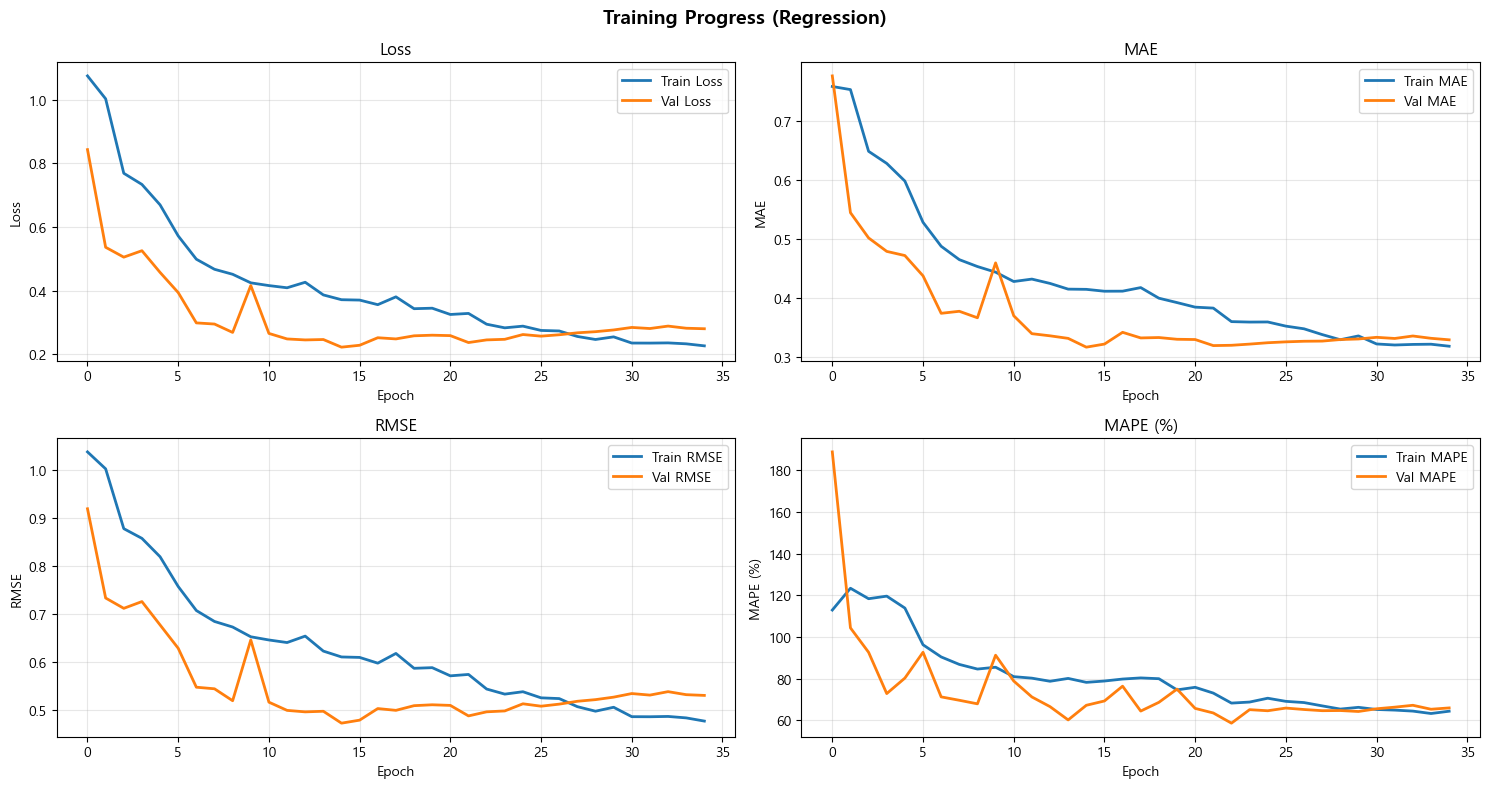

[Test]: 100%|██████████| 10/10 [00:00<00:00, 90.84it/s, loss=1.0149, mae=0.6959, rmse=1.0074]


=== 테스트 세트 평가(회귀) ===
Loss: 0.3967
MAE : 0.3838
RMSE: 0.6298
MAPE: 83.42%
R² (Output 1): 0.4999

✓ Predictions denormalized
  Original shape: (601, 1)
  Denormalized shape: (601, 1)

✓ Predictions saved to C:\project_WWTP\python\results\DL\flow_predictions.csv


(LSTMRegressor(
   (lstm): LSTM(31, 128, num_layers=4, batch_first=True, dropout=0.3)
   (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (attention): MultiheadAttention(
     (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
   )
   (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (head): Sequential(
     (0): Linear(in_features=128, out_features=256, bias=True)
     (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
     (2): ReLU()
     (3): Dropout(p=0.3, inplace=False)
     (4): Linear(in_features=256, out_features=128, bias=True)
     (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
     (6): ReLU()
     (7): Dropout(p=0.3, inplace=False)
     (8): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 {'train_loss': [1.075028832439615,
   1.0030094619358287,
   0.7689649096056193,
   0.7338800962632444,
   0.6697516549334807,
   0.5720612933455395,
   0.4988298800612698,

In [545]:
main()